## Проект: Прогнозирование уровня средней заработной платы в России

In [260]:
%pylab inline
import pandas as pd
import scipy as sp
import numpy as np
import sys
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


Populating the interactive namespace from numpy and matplotlib


In [175]:
print ('pandas version is '+'\t\t',pd.__version__)
print ('scipy version is '+'\t\t',sp.__version__)
print ('numpy version is '+'\t\t',np.__version__)
print ('statsmodels.api version is '+'\t',sm.__version__)
print ('Python version is '+'\t\t',sys.version[:6])

pandas version is 		 0.23.4
scipy version is 		 1.3.1
numpy version is 		 1.16.4
statsmodels.api version is 	 0.10.1
Python version is 		 3.7.4 


К исходному файлу были добавлены свежие данные.

Источник данных: Федеральная службагосударственной статистики

Файл от 20.12.2019 00:00

Ссылка:

https://www.gks.ru/search?q=Заработная+плата+статистика&date_from=&content=on&date_to=&search_by=all&sort=relevance

Последнее значение в файле с исходными данными

01.08.2016;<b>34095</b>

отличается от соответствующего значения, приведенного на сайте ФСС

01.08.2016;<b>35405</b>

В работе использовалось второе значение, соответствующее информации с сайта

In [91]:
DATA=pd.read_csv('WAG_C_M_check.csv', sep=';',index_col=['month'],parse_dates=['month'], dayfirst=True)
DATA.rename(columns={'WAG_C_M':'mean_salary'}, inplace=True)
print(DATA.head())
print(DATA.tail())
print("Измененное значение ", DATA.loc['2016-08-01'].values[0])

            mean_salary
month                  
1993-01-01         15.3
1993-02-01         19.1
1993-03-01         23.6
1993-04-01         30.6
1993-05-01         37.5
            mean_salary
month                  
2019-06-01      49348.0
2019-07-01      46509.0
2019-08-01      44961.0
2019-09-01      45541.0
2019-10-01      46549.0
Измененное значение  35405.0


### 1. Визуальный анализ ряда

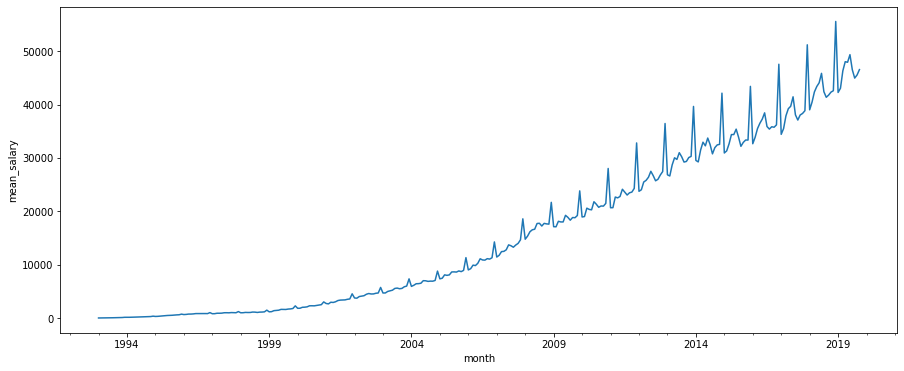

In [94]:
plt.figure(figsize=(15,6))
DATA.mean_salary.plot()
plt.ylabel('mean_salary')
pylab.show()

При визуальном анализе сразу четко определяется присутствие сезонности и ярко выраженного тренда в исследуемом ряду, следовательно, наш ряд нестационарный.

Проведем формальную проверку стацинарности с помощью критерия Дикки-Фуллера и сделаем STL-декомпозицию исходного ряда.

Критерий Дики-Фуллера: p=0.998750


<Figure size 1080x720 with 0 Axes>

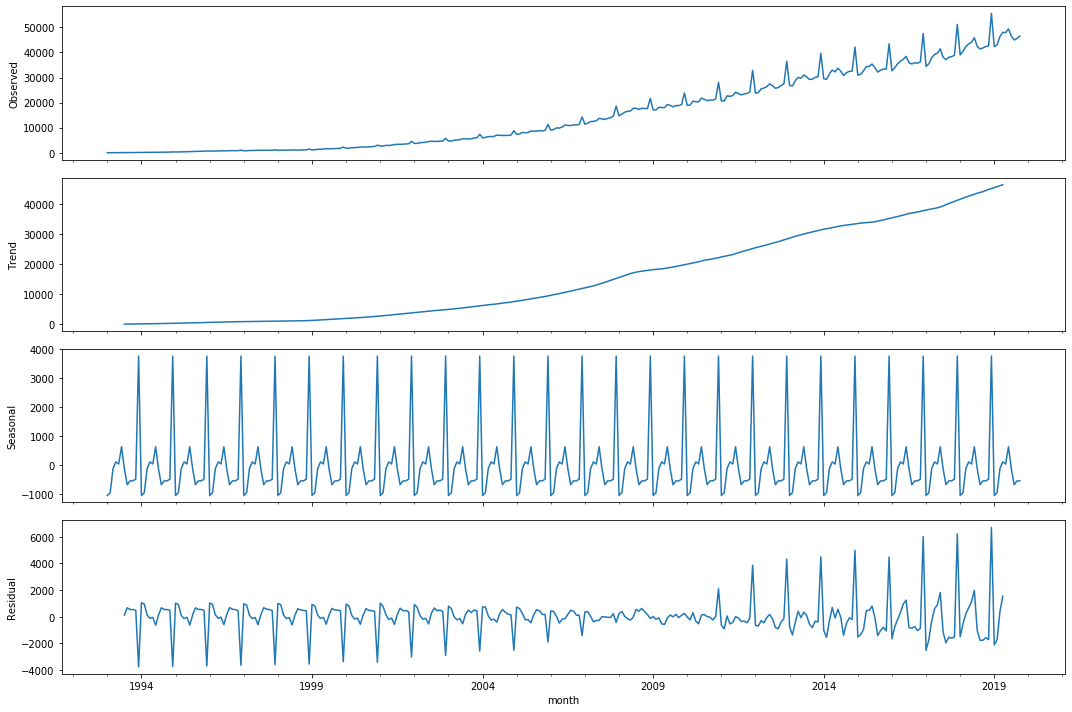

In [100]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(DATA.mean_salary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DATA.mean_salary)[1])
plt.show()

Гипотеза о нестационарности не отвергается критерием Дики-Фуллера с большим уровнем значимости, что соответствует первичной визуальной оценке.

### 2. Приведение исходного ряда к стационарному

Согласно теореме Вольда, для того, чтобы использовать модели из класса ARMA для прогнозирования временного ряда, нобходимо, чтобы он был стацинарен.

Приведение исходного ряда к стационарному осуществляем двумя способами:

1.Стабилизация дисперсии (преобразование Бокса-Кокса)

2.Дифференцирование (сезонное и обычное)

#### 2.1.Стабилизация дисперсии 

Сделаем преобразование Бокса-Кокса:

Оптимальный параметр преобразования Бокса-Кокса: 0.288242
Критерий Дики-Фуллера: p=0.723344


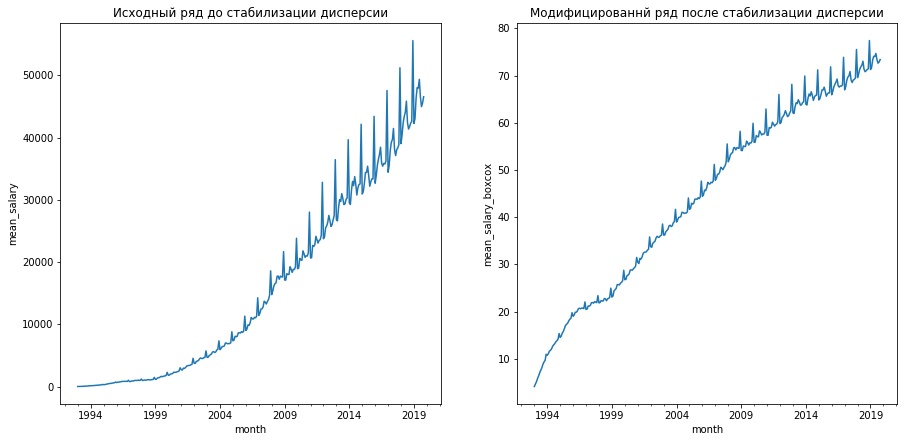

In [153]:
DATA['mean_salary_boxcox'], lmbda = stats.boxcox(DATA.mean_salary)
plt.figure(figsize(15,7))

pylab.subplot(1,2,1)
DATA.mean_salary.plot()
plt.ylabel(u'mean_salary')
plt.title('Исходный ряд до стабилизации дисперсии')

pylab.subplot(1,2,2)
DATA.mean_salary_boxcox.plot()
plt.ylabel(u'mean_salary_boxcox')
plt.title('Модифицированнй ряд после стабилизации дисперсии')

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DATA.mean_salary_boxcox)[1])

Мы видим, что дисперсия несколько стабилизировалась, разница в размахе сезонных колебаний в начале и в конце ряда уменьшилась, по сравнению с сооответствующей разницей для исходного ряда, но Критерий Дики-Фуллера все еще не отклоняет нулевую гипотезу о нестационарности ряда с высоким уровнем значимости, но уже меньшим, чем для исходного ряда.

#### 2.2. Дифференцирование

Сезонное дифференцирование для модернизированного ряда, после преобразования Бокса-Кокса

Критерий Дики-Фуллера: p=0.122454


<Figure size 1080x720 with 0 Axes>

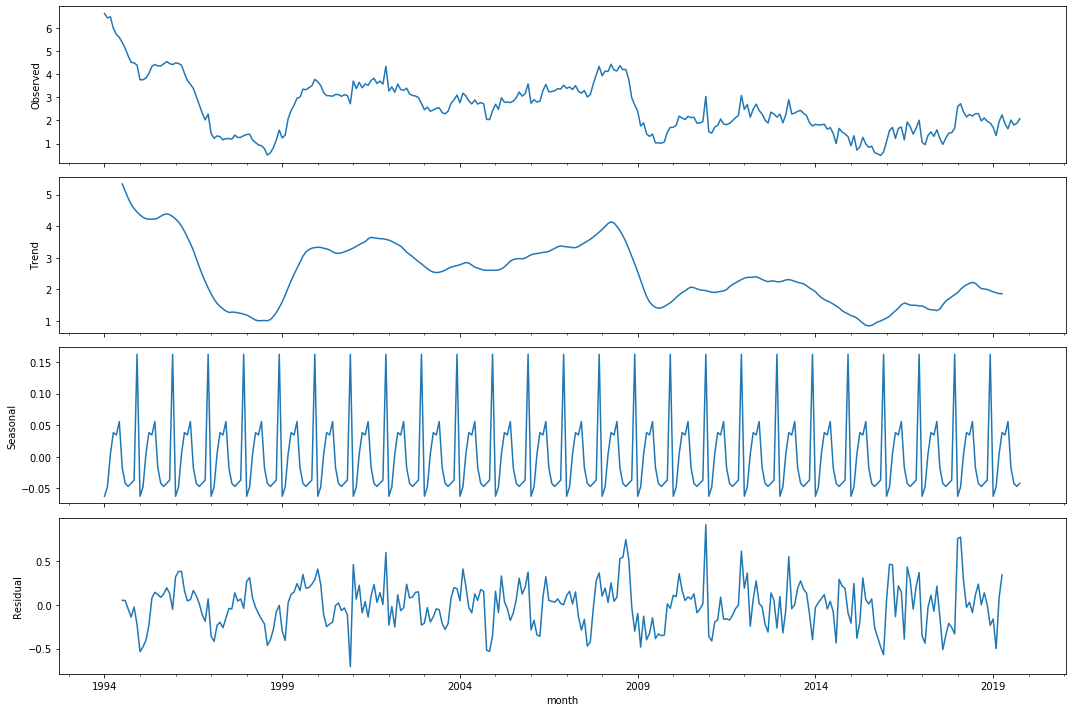

In [156]:
DATA['mean_salary_boxcox_seas_dif'] = DATA.mean_salary_boxcox - DATA.mean_salary_boxcox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(DATA.mean_salary_boxcox_seas_dif[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(DATA.mean_salary_boxcox_seas_dif[12:])[1])

После сезонного диф. мы видим сильное изменение линии тренда, относительно исходного ряда, но тренд все еще не является константным, прослеживается систематическое снижение значений линии тренда. 

Критерий Дики-Фулера все еще не отклоняет гипотезу о нестацинарности ряда на уровне значимости 0.05, но мы наблюдаем сильное снижения достигаемого в критерии p-value.

Проведем обычное дифференцирование для модернизированного ряда, для которого предварительно были проведены:

1) Преобразование Бокса-Кокса

2) Сезонное дифференцирование

Критерий Дики-Фуллера: p=4.03445e-10


<Figure size 1080x720 with 0 Axes>

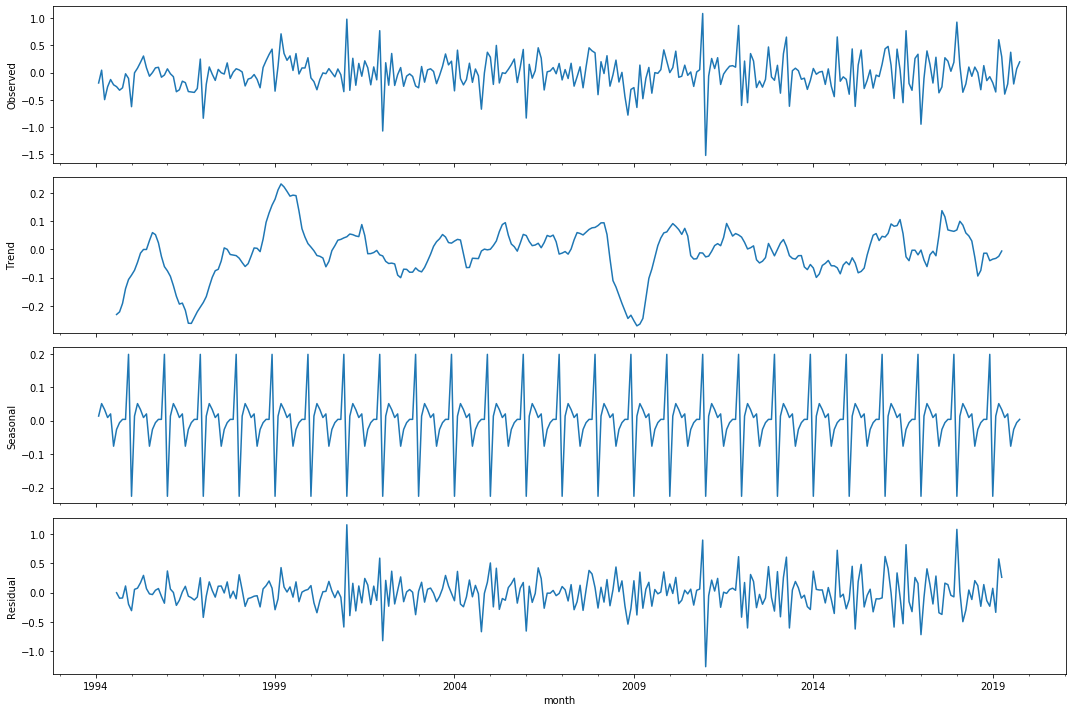

In [164]:
DATA['mean_salary_boxcox_seas_dif_us_dif'] = DATA.mean_salary_boxcox_seas_dif - DATA.mean_salary_boxcox_seas_dif.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(DATA.mean_salary_boxcox_seas_dif_us_dif[13:]).plot()
print("Критерий Дики-Фуллера: p=%g" % sm.tsa.stattools.adfuller(DATA.mean_salary_boxcox_seas_dif_us_dif[13:])[1])

Тренд колеблится вокруг константы, отсутствует какая-то систематичность в поведении.
Критерий Дикки-Фулера уверенно отвергает гипотезу о нестационарности с оровнем значимости порядка p=4e-10.

Полученный ряд можно считать стационарным.

## 3. Выбор модели

Т.к. для приведения ряда к стационарному мы использовали сезонное и обычное дифференцирование, то будем использовать, соответствующую модуль

<b>SARIMA (p,q,d) x (P,Q,D)

Проведем процедуру подбора начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного ряда:

In [295]:
Final_Series=DATA.mean_salary_boxcox_seas_dif_us_dif[13:]

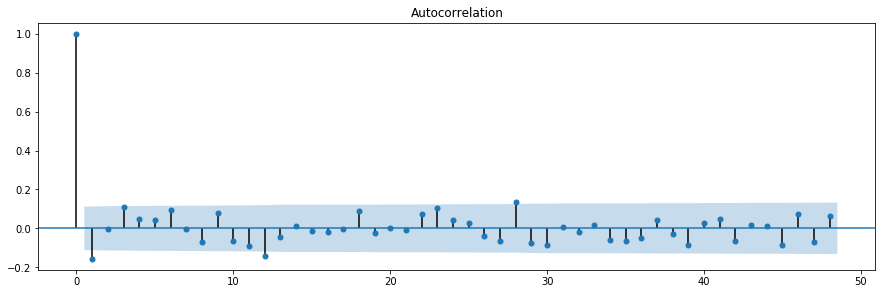

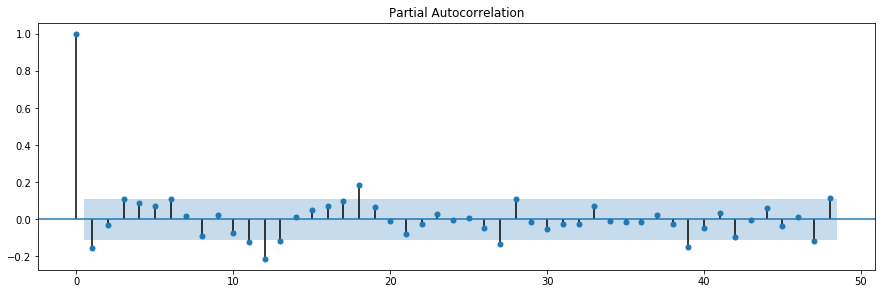

In [296]:
plt.figure(figsize(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(Final_Series.values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(Final_Series.values.squeeze(), lags=48, ax=ax)
pylab.show()

по ACF выбираем Q и q:

In [298]:
S=12 #сезон = 12 месяцев
NUMB_LAST_SEAS_LAG = 12
Q=int(NUMB_LAST_SEAS_LAG / S)
print('Q =',Q)
print ('q =',q)

Q = 1
q = 1


по PACF выбираем P и p:

In [299]:
NUMB_LAST_SEAS_LAG = 12
P=int(NUMB_LAST_SEAS_LAG / S)
print('P =',P)
NONSEAS_LAG=[1,18,27,39]
print ('p =',p)

P = 1
p = 1


выбираем p из значимых несезонных лагов в начале PACF

In [261]:
ps=range(2)
qs=range(2)
Ps=range(2)
Qs=range(2)
d=1
D=1

In [262]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (len(parameters_list))

16


In [301]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(DATA.mean_salary_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 3.06 s


In [302]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(10))

      parameters         aic
6   (0, 1, 1, 0)  145.277095
10  (1, 0, 1, 0)  145.373736
7   (0, 1, 1, 1)  145.429622
11  (1, 0, 1, 1)  145.675139
5   (0, 1, 0, 1)  146.328530
9   (1, 0, 0, 1)  146.397658
14  (1, 1, 1, 0)  147.069350
15  (1, 1, 1, 1)  147.241622
13  (1, 1, 0, 1)  148.143635
8   (1, 0, 0, 0)  152.807237


In [303]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                 mean_salary_boxcox   No. Observations:                  322
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -69.639
Date:                            Sat, 21 Dec 2019   AIC                            145.277
Time:                                    04:14:09   BIC                            156.477
Sample:                                01-01-1993   HQIC                           149.755
                                     - 10-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1837      0.041     -4.533      0.000      -0.263      -0.104
ar.S.L12      -0.1823      0.041   

рассмотрим остатки лучшей модели

Критерий Стьюдента: p=0.214862
Критерий Дики-Фуллера: p=1.71121e-06


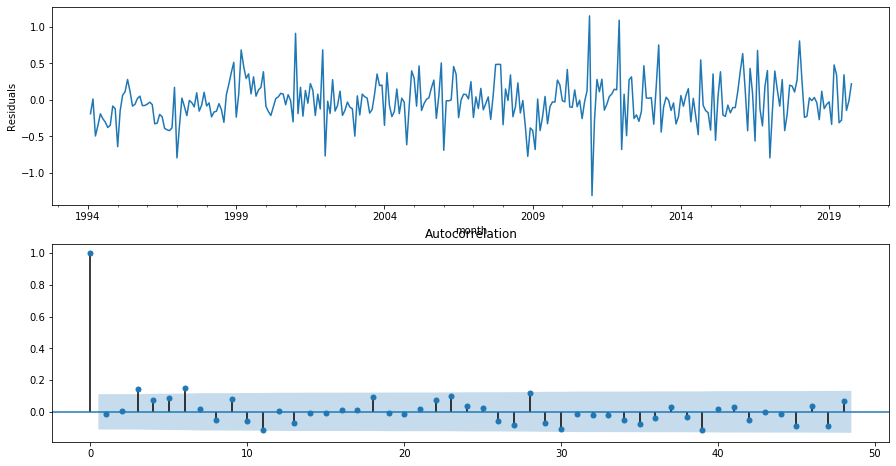

In [304]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%g" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [350]:
a=sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

In [363]:
a=sm.graphics.tsa.acf(best_model.resid[13:].values.squeeze())

In [369]:
a[sm.graphics.tsa.acf(best_model.resid[13:].values.squeeze())>0.05]

array([1.        , 0.14235781, 0.07526524, 0.08590533, 0.15135476,
       0.08215751, 0.094951  , 0.0737068 , 0.10176638, 0.11812849])

1) Критерий стъюдента не позволяет отклонить гипотезу о том, что среднее значения остатков равно 0, следовательно, гипотезу о том, что остатки несмещенные.

2) Критерий Дики-Фулера уверенно отклоняет гипотезу о нестационарности, с кровнем значимости p=1.71121e-06.

3) По коррелограмме можно сделать вывод о том, что остатки являются неавтокоррелированными (в них отсутствует какая-либо неучтенная зависимость от предыдущих наблюдений, - на коррелограмме отсутствуют какая-то структура, есть только два лага, значимо отличающихся от нуля.

Остатки

1)Несмещены

2)Стационарны

3)Неавтокоррелированны 


Проверим визуально качество модели (насколько хорошо она описывает исходный ряд)

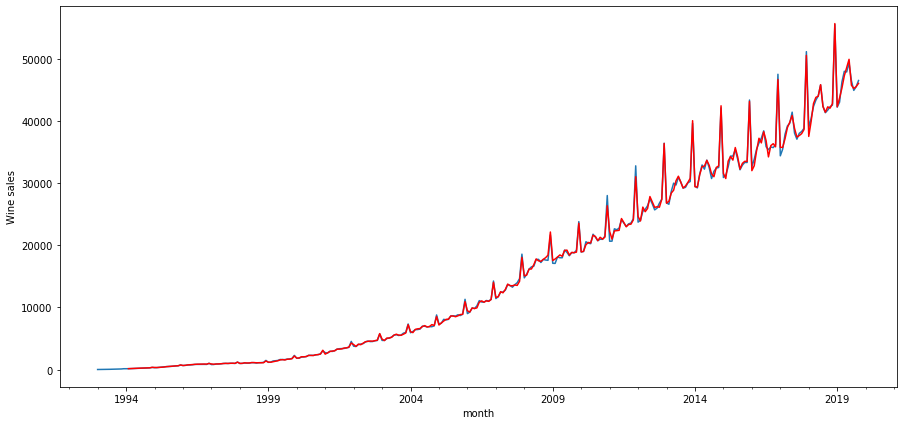

In [291]:
DATA['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
DATA.mean_salary.plot()
DATA.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Видим, что модель очень хорошо описывает наши данные

### 4. Построение прогноза

Строим прогноз на два года вперед на каждый месяц от 01.11.2019

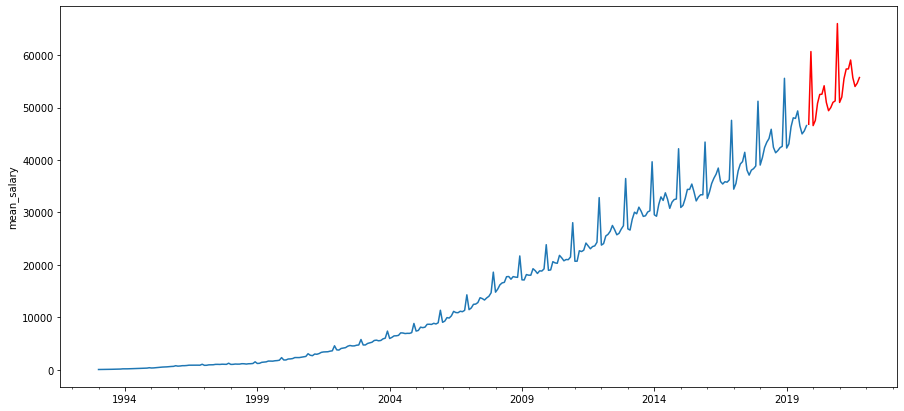

In [315]:

DATA2 = DATA[['mean_salary']]
date_list = [datetime.datetime.strptime("2019-11-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= DATA2.columns)
DATA2 = pd.concat([DATA2, future])
DATA2['forecast'] = invboxcox(best_model.predict(start=DATA.shape[0], end=DATA.shape[0]+24), lmbda)

plt.figure(figsize(15,7))
DATA2.mean_salary.plot()
DATA2.forecast.plot(color='r')
plt.ylabel('mean_salary')
pylab.show()

Вывод:
Построенный прогноз повторяет ту же сезонность, что и исходный ряд. Направление тренда соответствует исходному, дисперсия - увеличивается, что отражает общую закономерность.

In [344]:
#сезонный разброс средней зарплаты с 2018-11-01 по 2019-10-01 (последний измеренный период в ряде)
DATA.mean_salary.iloc[310:322,].max()-DATA.mean_salary.iloc[310:322,].min()

13306.0

In [346]:
#сезонный разброс на следующий год (2020)
DATA2['forecast'].iloc[322:334,].max()-DATA2['forecast'].iloc[322:334,].min()

14127.60385637833

In [347]:
#сезонный разброс на следующий 2021
DATA2['forecast'].iloc[334:,].max()-DATA2['forecast'].iloc[334:,].min()

15048.683525932356